In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from graph_util.visualization_util import make_graph_visual
from scheduling_util.modified_etf import Mod_ETF
from scheduling_util.consolidated_functions import opt_schedule_given_ordering
from scheduling_util.heuristics import native_rescheduler
from graph_util.random_graph_functions import random_all_fork, random_all_join
from graph_util.erdos_renyi_dag import er_dag
from scheduling_util.approx_pseudosizes import speed_to_psize
from sklearn import linear_model
from statsmodels.formula.api import ols

## Add to feature set:

In [2]:
feature_id = ['in_degree', 'out_degree', 'num_descendants', 'longest_descendant_path', 'in_degree_betweenness_centrality', 'out_degree_betweenness_centrality', 'trophic_levels']    

def get_feature_set(G, psize):
    
    lst = []
    in_degree_lst = G.in_degree
    out_degree_lst = G.out_degree
    in_bet_lst = nx.algorithms.in_degree_centrality(G)
    out_bet_lst = nx.algorithms.out_degree_centrality(G)
    trophic_lst = nx.algorithms.trophic_levels(G)
    for node in G.nodes:
        in_degree = in_degree_lst[node]
        out_degree = out_degree_lst[node]
        in_bet = in_bet_lst[node]
        # print("in betweennes", in_bet)
        out_bet = out_bet_lst[node]
        trophic = trophic_lst[node]
        # print("out_betweennes", out_bet)
        descendants = list(nx.algorithms.dag.descendants(G, node))
        descendants.append(node)
        num_descendants = len(descendants) 
        longest_descendant_path = nx.dag_longest_path_length(G.subgraph(descendants)) 
        lst.append((in_degree, out_degree, num_descendants, longest_descendant_path, in_bet, out_bet, trophic, psize[node]))      
    return lst

## Create Groundtruth Data:

In [3]:
data = []

tie_breaking_rule = 2
# num_tasks = 15
# num_machines = 3
probability = 0.3

for i in range(1, 20):
    print("I is ", i)
    for k in range(5):  
        num_tasks = i + 5
        num_machines = 3
        w = [1 for _ in range(num_tasks)]
        s = [1 for _ in range(num_tasks)]
        p = [1 for _ in range(num_tasks)]
        G, _ = er_dag(num_tasks, probability)
        assert(nx.algorithms.dag.is_directed_acyclic_graph(G))
        etf = Mod_ETF(G, w, s, num_machines, tie_breaking_rule, plot=False)
        intervals, speeds, obj_value = opt_schedule_given_ordering(True, G, w, p, etf.order, plot=False, compare=False)
        if speeds[0] !=-1:
            psize = speed_to_psize(speeds)
            feature_set = get_feature_set(G, psize)
                # make_graph_visual(G, num_tasks)
            data = data + feature_set


I is  1
I is  2
I is  3
I is  4
I is  5
I is  6
I is  7
I is  8
I is  9
I is  10
I is  11
I is  12
I is  13
I is  14
I is  15
I is  16
I is  17
I is  18
I is  19


## Visually verify correlation between feature and pseudosize:

In [4]:
#load data into Dataframe
df = pd.DataFrame.from_records(data, columns=['in_degree', 'out_degree', 'num_descendants', 'longest_descendant_path','in_degree_betweenness_centrality', 'out_degree_betweenness_centrality', 'trophic_levels','psize'])    

Feature: in_degree


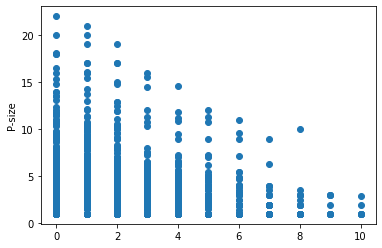

----
Feature: out_degree


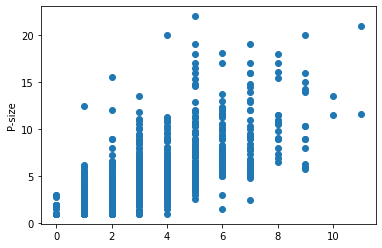

----
Feature: num_descendants


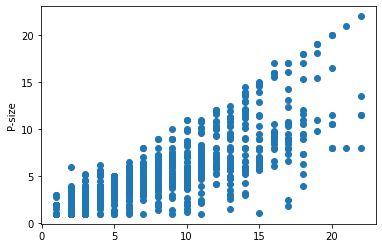

----
Feature: longest_descendant_path


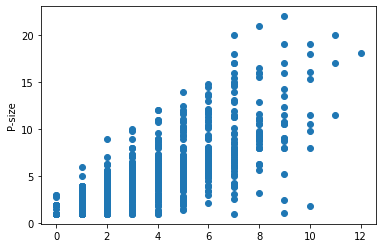

----
Feature: in_degree_betweenness_centrality


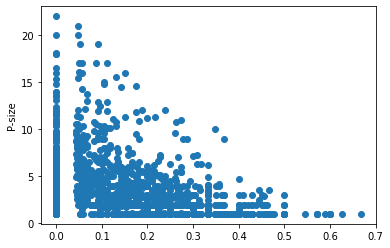

----
Feature: out_degree_betweenness_centrality


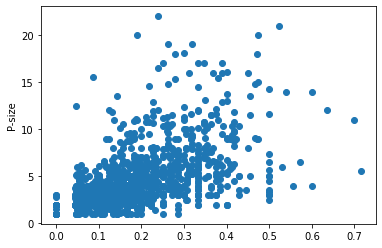

----
Feature: trophic_levels


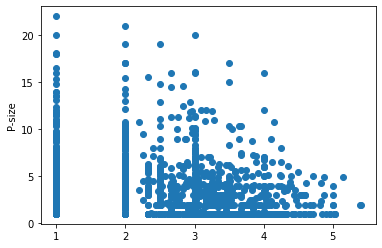

----


In [5]:
for col in df.columns:
    if col == 'psize':
        continue
    print('Feature: ' + col)
    plt.scatter(df[col], df.psize)
    plt.ylabel('P-size')
    plt.show()
    print('----')

# Get Model Summary to see which variables are important and which are not

In [6]:
import statsmodels.api as sm

X = df[['in_degree', 'out_degree', 'num_descendants', 'longest_descendant_path', 'in_degree_betweenness_centrality', 'out_degree_betweenness_centrality', 'trophic_levels']]
X = sm.add_constant(X)
Y = df['psize']
model=sm.OLS(Y, X.astype(float)).fit()
predictions=model.predict(X)
print_model=model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  psize   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     514.0
Date:                Thu, 28 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:27:43   Log-Likelihood:                -2637.2
No. Observations:                1343   AIC:                             5290.
Df Residuals:                    1335   BIC:                             5332.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

# Train Sklearn Linear Regression Model

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
lr = LinearRegression()
import numpy as np
lr.fit(X, Y)
print(f'R-Squared : {lr.score(X, Y)}')

R-Squared : 0.7293564624930413


# Helper Functions

In [8]:
def compute_cost(w, t, s):
    '''
    Given weights w, time intervals t, and speeds s, compute the cost of the schedule; 
    returns total cost as well as separate power and time components.
    '''
    power = 0
    time = 0
    # print(t)
    for j in range(len(s)):
        if t[j] == -1:
            return -1, -1, -1
        power += w[j] * s[j]
        time += t[j][1]
    total_cost = power + time
    return total_cost, power, time

def psize_to_speed(psize):
    return [np.sqrt(psize[i])for i in range(len(psize))]


# Run Testing Data Simulation (Ignore the warnings)

In [9]:
data = []
greedy_objectives = []
lr_objective = []
lengths = []
tie_breaking_rule = 2
greedy_psizes = []
lr_psizes = []
# num_tasks = 15
# num_machines = 3
probability = 0.3

for i in range(1, 20):
    print("I is ", i)
    for k in range(5):  
        num_tasks = i + 5
        num_machines = 3
        w = [1 for _ in range(num_tasks)]
        s = [1 for _ in range(num_tasks)]
        p = [1 for _ in range(num_tasks)]
        G, _ = er_dag(num_tasks, probability)
        assert(nx.algorithms.dag.is_directed_acyclic_graph(G))
        etf = Mod_ETF(G, w, s, num_machines, tie_breaking_rule, plot=False)
        intervals, speeds, obj_value = opt_schedule_given_ordering(True, G, w, p, etf.order, plot=False, compare=False)
        psize = speed_to_psize(speeds)
        cost, power, time = compute_cost(w, intervals, speeds)
        if cost != -1:
            greedy_objectives.append([cost, power, time])
            feature_set = get_feature_set(G, psize)
            # make_graph_visual(G, num_tasks)
            # data = data + feature_set
            df = pd.DataFrame.from_records(feature_set, columns=['in_degree', 'out_degree', 'num_descendants', 'longest_descendant_path','in_degree_betweenness_centrality', 'out_degree_betweenness_centrality', 'trophic_levels','psize'])
            X = df[['in_degree', 'out_degree', 'num_descendants', 'longest_descendant_path', 'in_degree_betweenness_centrality', 'out_degree_betweenness_centrality', 'trophic_levels']]
            X = sm.add_constant(X)
            lr_psize = lr.predict(feature_set)
            greedy_psizes.append(psize)
            lr_psizes.append(lr_psize)
            lr_speeds = psize_to_speed(lr_psize)
            lr_time_intervals = native_rescheduler(G, lr_speeds, w, etf.order)
            lr_cost, lr_power, lr_time = compute_cost(w,lr_time_intervals ,lr_speeds)
            lr_objective.append([lr_cost, lr_power, lr_time])
            lengths.append(len(G))

I is  1


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  2


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  3


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  4


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  5


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  6


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  7


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


I is  8


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


I is  9


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  10


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


I is  11


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


I is  12


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  13


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


I is  14


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  15


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


I is  16


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  17


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


I is  18


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  19


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

In [10]:
# df = pd.DataFrame.from_records(data, columns=['in_degree', 'out_degree', 'num_descendants', 'longest_descendant_path','in_degree_betweenness_centrality', 'out_degree_betweenness_centrality', 'trophic_levels','psize'])
# print(df)
print("greedy objectives\n",greedy_objectives)
print("lr_objectives\n",lr_objective)
print(lengths)

greedy objectives
 [[17.22352, 8.61177, 8.61175], [15.3137, 7.65684, 7.65686], [19.02798, 9.51399, 9.51399], [14.48528, 7.24264, 7.242640000000001], [15.152989999999999, 7.57649, 7.5765], [18.95741, 9.4787, 9.47871], [17.949399999999997, 8.974689999999999, 8.974709999999998], [18.58506, 9.29252, 9.29254], [18.585069999999998, 9.29253, 9.292539999999999], [21.59308, 10.79654, 10.796539999999998], [23.606230000000004, 11.80312, 11.803110000000002], [21.41348, 10.70674, 10.706740000000002], [23.77583, 11.887920000000001, 11.88791], [22.63629, 11.31815, 11.31814], [24.531440000000003, 12.26573, 12.265710000000002], [28.531440000000003, 14.265730000000001, 14.26571], [29.638250000000003, 14.819130000000001, 14.819120000000002], [27.06037, 13.53019, 13.53018], [27.263060000000003, 13.631530000000001, 13.631530000000001], [25.776540000000004, 12.888260000000002, 12.888280000000002], [30.752139999999997, 15.376079999999998, 15.376059999999999], [30.920990000000003, 15.460500000000001, 15.46049

In [11]:
objective_comparisons = [l[0]/g[0] for g, l in zip(greedy_objectives, lr_objective)]
power_comparisons = [l[1]/g[1] for g, l in zip(greedy_objectives, lr_objective)]
time_comparisons = [l[2]/g[2] for g, l in zip(greedy_objectives, lr_objective)]

print("objective ratio \n", objective_comparisons)
print("power comparisons \n", power_comparisons)
print("time comparisons \n", time_comparisons)

objective ratio 
 [1.4132846355247781, 1.330054354987884, 1.3764168177667526, 1.2703747610079228, 1.3148568535172995, 1.3721029416752306, 1.2662655296729188, 1.3148841614749782, 1.2711356576475064, 1.3199040852963357, 1.310529430151458, 1.3009374817166939, 1.2674436687315536, 1.2672793015028705, 1.4053970749185116, 1.3579350626832127, 1.3932126888698875, 1.2709019772038874, 1.312350535919968, 1.3000469541664534, 1.367744137030447, 1.3057969106341691, 1.4103131880202158, 1.3417383023574685, 1.3115715884905061, 1.3319092430099873, 1.2576420024525667, 1.3314427277794525, 1.2715675296645186, 1.2785159219411035, 1.3407901284072121, 1.3275658358364224, 1.276238625985516, 1.3270840648463154, 1.248885367603128, 1.2826977016291996, 1.3645149713640423, 1.2525692238299317, 1.2433569996737945, 1.2566443936226603, 1.288441923943872, 1.2348997645045712, 1.258043490271823, 1.2611853860593332, 1.2229173635806396, 1.3118610969572106, 1.2871071154016105, 1.2690002151808482, 1.2267162139657426, 1.3063565

# Plots based on the Objectives

/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1152x576 with 0 Axes>

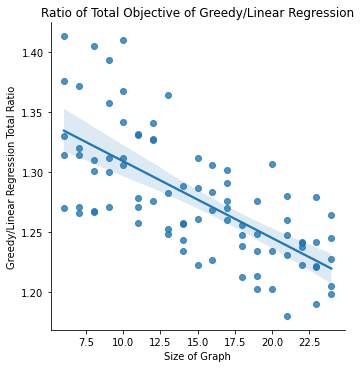

/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1152x576 with 0 Axes>

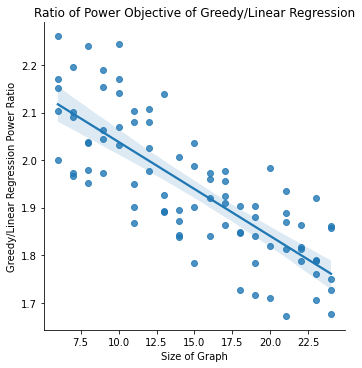

/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1152x576 with 0 Axes>

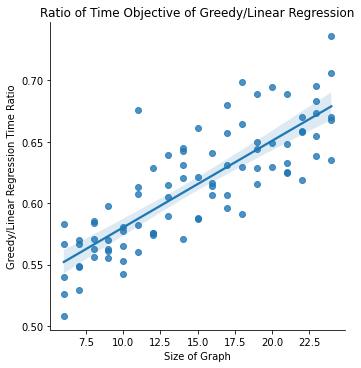

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# # Run model on test data and visualize prediction accuracy
# y_hat = lr.predict(X_test)
# print("predictions are ",y_hat)
# plt.figure(figsize=(16,8))
# sns.distplot(y_hat, hist = False, label = f'Predicted Pseudosize')
# sns.distplot(Y_test, hist = False, label = f'Actual Pseudosize')
# plt.title(f'Actual vs Predicted Pseudosize')
# plt.xlabel('Pseudosize')
# plt.ylabel('Density')
# plt.show()
plt_df = pd.DataFrame.from_dict({"objective_ratio": objective_comparisons, "power_ratio": power_comparisons, "time_ratio":time_comparisons, "size":lengths})

plt.figure(figsize=(16,8))
sns.lmplot("size", "objective_ratio", plt_df, order=1)
plt.title("Ratio of Total Objective of Greedy/Linear Regression")
plt.xlabel("Size of Graph")
plt.ylabel("Greedy/Linear Regression Total Ratio")
plt.show()

plt.figure(figsize=(16,8))
sns.lmplot("size", "power_ratio", plt_df, order=1)
plt.title("Ratio of Power Objective of Greedy/Linear Regression")
plt.xlabel("Size of Graph")
plt.ylabel("Greedy/Linear Regression Power Ratio")
plt.show()

plt.figure(figsize=(16,8))
sns.lmplot("size", "time_ratio", plt_df, order=1)
plt.title("Ratio of Time Objective of Greedy/Linear Regression")
plt.xlabel("Size of Graph")
plt.ylabel("Greedy/Linear Regression Time Ratio")
plt.show()

# Plots based on the Loss (OLS)

/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1152x576 with 0 Axes>

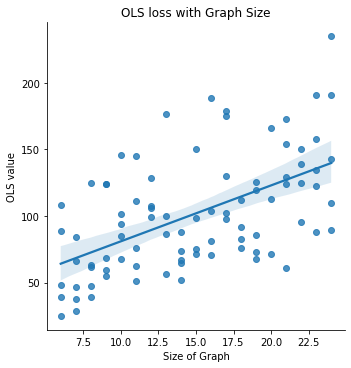

/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1152x576 with 0 Axes>

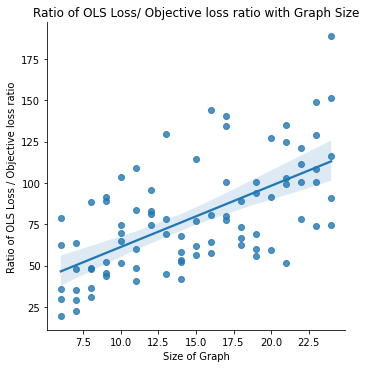

Mean OLS loss is  101.20448844775937
Square root of OLS loss is  10.060044157346397


In [15]:
import statistics

def ols(list1, list2):
    return [(l1-l2)**2 for l1, l2 in zip(list1, list2)]

# #print(y_hat)
# #print(Y_test)
# y_hat = list(y_hat)
mean_squares = [statistics.mean(ols(g, l)) for g, l in zip(greedy_psizes, lr_psizes)]
loss_ratio = [a / b for a, b in zip(mean_squares, objective_comparisons)]

plt_df = pd.DataFrame.from_dict({"objective_ratio": objective_comparisons, "power_ratio": power_comparisons, "time_ratio":time_comparisons, "size":lengths, "ols_loss":mean_squares, "loss_ratio":loss_ratio})

plt.figure(figsize=(16,8))
sns.lmplot("size", "ols_loss", plt_df, order=1)
plt.title("OLS loss with Graph Size")
plt.xlabel("Size of Graph")
plt.ylabel("OLS value")
plt.show()

plt.figure(figsize=(16,8))
sns.lmplot("size", "loss_ratio", plt_df, order=1)
plt.title("Ratio of OLS Loss/ Objective loss ratio with Graph Size")
plt.xlabel("Size of Graph")
plt.ylabel("Ratio of OLS Loss / Objective loss ratio")
plt.show()

mean_loss = statistics.mean(mean_squares)
print("Mean OLS loss is ", mean_loss)
print("Square root of OLS loss is ", mean_loss ** (0.5))


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1152x576 with 0 Axes>

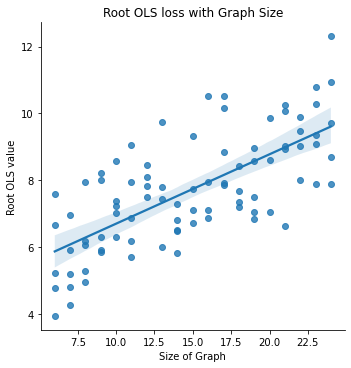

In [16]:
import statistics

def ols(list1, list2):
    return [(l1-l2)**2 for l1, l2 in zip(list1, list2)]

# #print(y_hat)
# #print(Y_test)
# y_hat = list(y_hat)
root_mean_squares = [statistics.mean(ols(g, l))**0.5 for g, l in zip(greedy_psizes, lr_psizes)]
root_loss_ratio = [a / b for a, b in zip(root_mean_squares, objective_comparisons)]

plt_df = pd.DataFrame.from_dict({"objective_ratio": objective_comparisons, "power_ratio": power_comparisons, "time_ratio":time_comparisons, "size":lengths, "ols_loss":mean_squares, "loss_ratio":loss_ratio, "root_loss_ratio":root_loss_ratio})

plt.figure(figsize=(16,8))
sns.lmplot("size", "root_loss_ratio", plt_df, order=1)
plt.title("Root OLS loss with Graph Size")
plt.xlabel("Size of Graph")
plt.ylabel("Root OLS value")
plt.show()

